In [2]:
# -------------------------------------------
# 1. ÎùºÏù¥Î∏åÎü¨Î¶¨ ÏûÑÌè¨Ìä∏
# -------------------------------------------
import pandas as pd
import numpy as np
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import statsmodels.api as sm
from datetime import datetime
from statsmodels.tsa.stattools import coint

try:
    from pykalman import KalmanFilter
except ImportError:
    print("error")
    KalmanFilter = None

# Matplotlib Ïä§ÌÉÄÏùº Î∞è ÌïúÍ∏Ä Ìè∞Ìä∏ ÏÑ§Ï†ï
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['font.family'] = 'AppleGothic' # Windows: 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False
print("ÎùºÏù¥Î∏åÎü¨Î¶¨ Ï§ÄÎπÑ ÏôÑÎ£å")

ÎùºÏù¥Î∏åÎü¨Î¶¨ Ï§ÄÎπÑ ÏôÑÎ£å


In [9]:
# -------------------------------------------
# 2. Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ï§ÄÎπÑ
# -------------------------------------------
clusters_dict = {
    0: ['Nikkei 225', 'Taiwan', 'S&P 500', 'Dow Jones', 'NASDAQ', 'S&P/TSX', 'FTSE 100', 'DAX', 'CAC 40', 'EURO STOXX 50'],
    1: ['KOSPI', 'Shanghai', 'Hang Seng']
}

indices_tickers = {
    'KOSPI': 'KS11', 'Nikkei 225': 'N225', 'Shanghai': 'SSEC', 'Hang Seng': 'HSI', 'Taiwan': '^TWII',
    'S&P 500': 'US500', 'Dow Jones': 'DJI', 'NASDAQ': 'IXIC', 'S&P/TSX': '^GSPTSE',
    'FTSE 100': 'FTSE', 'DAX': 'GDAXI', 'CAC 40': 'FCHI', 'EURO STOXX 50': '^STOXX50E'
}

start_date = '2023-01-01'
end_date = datetime.today().strftime('%Y-%m-%d')


all_indices_in_clusters = [name for cluster in clusters_dict.values() for name in cluster]
all_tickers_to_fetch = {name: ticker for name, ticker in indices_tickers.items() if name in all_indices_in_clusters}

print(f"üìà Ï¥ù {len(all_tickers_to_fetch)}Í∞ú ÏßÄÏàòÏùò Îç∞Ïù¥ÌÑ∞Î•º ÏàòÏßëÌï©ÎãàÎã§ ({start_date} ~ {end_date})...")

prices_df = pd.DataFrame()
for name, ticker in all_tickers_to_fetch.items():
    try:
        stock_data = fdr.DataReader(ticker, start_date, end_date)['Close']
        prices_df[name] = stock_data
    except Exception as e:
        print(f"  - {name} ({ticker}) Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Ïã§Ìå®: {e}")

prices_df.dropna(inplace=True)
print("Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ï§ÄÎπÑ ÏôÑÎ£å")

üìà Ï¥ù 13Í∞ú ÏßÄÏàòÏùò Îç∞Ïù¥ÌÑ∞Î•º ÏàòÏßëÌï©ÎãàÎã§ (2023-01-01 ~ 2025-08-30)...
Îç∞Ïù¥ÌÑ∞ ÏàòÏßë Î∞è Ï§ÄÎπÑ ÏôÑÎ£å


In [11]:
# -------------------------------------------
# 3. Í∞ôÏùÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎÇ¥ ÌéòÏñ¥ ÌÉêÏÉâ
# -------------------------------------------
def find_intra_cluster_pairs(data, tickers_list, threshold=0.05):
    pairs = []
    for i in range(len(tickers_list)):
        for j in range(i + 1, len(tickers_list)):
            S1 = data.get(tickers_list[i])
            S2 = data.get(tickers_list[j])
            if S1 is None or S2 is None or len(S1) < 50:
                continue
            
            _, pvalue, _ = coint(S1, S2)
            if pvalue < threshold: 
                pairs.append((tickers_list[i], tickers_list[j], pvalue))
    return pairs

print("\n--- Í∞ôÏùÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎÇ¥ Í≥µÏ†ÅÎ∂Ñ ÌéòÏñ¥ ÌÉêÏÉâ (p-value < 0.05) ---")
all_intra_cluster_pairs = []
for i, cluster_names in clusters_dict.items():
    print(f"\n  [ÌÅ¥Îü¨Ïä§ÌÑ∞ {i}]")
    # prices_dfÏóê Ï°¥Ïû¨ÌïòÎäî ÏßÄÏàò Ïù¥Î¶ÑÎßåÏúºÎ°ú ÌéòÏñ¥ ÌÉêÏÉâ ÏàòÌñâ
    available_names = [name for name in cluster_names if name in prices_df.columns]
    pairs = find_intra_cluster_pairs(prices_df, available_names)
    
    if pairs:
        pairs.sort(key=lambda x: x[2])
        for p in pairs:
            print(f"    - {p[0]}-{p[1]}: {p[2]:.4f}")
        all_intra_cluster_pairs.extend(pairs)
    else:
        print("    Ïú†ÏùòÎØ∏Ìïú Í≥µÏ†ÅÎ∂Ñ ÌéòÏñ¥Î•º Ï∞æÏßÄ Î™ªÌñàÏäµÎãàÎã§.")

print("1Ï∞® ÌéòÏñ¥ ÌÉêÏÉâ ÏôÑÎ£å!")


--- Í∞ôÏùÄ ÌÅ¥Îü¨Ïä§ÌÑ∞ ÎÇ¥ Í≥µÏ†ÅÎ∂Ñ ÌéòÏñ¥ ÌÉêÏÉâ (p-value < 0.05) ---

  [ÌÅ¥Îü¨Ïä§ÌÑ∞ 0]
    - Dow Jones-NASDAQ: 0.0091
    - S&P 500-Dow Jones: 0.0095

  [ÌÅ¥Îü¨Ïä§ÌÑ∞ 1]
    Ïú†ÏùòÎØ∏Ìïú Í≥µÏ†ÅÎ∂Ñ ÌéòÏñ¥Î•º Ï∞æÏßÄ Î™ªÌñàÏäµÎãàÎã§.
1Ï∞® ÌéòÏñ¥ ÌÉêÏÉâ ÏôÑÎ£å!



‚úÖ [ÏπºÎßå ÌïÑÌÑ∞] Ï¥ù 2Í∞ú ÌéòÏñ¥Ïóê ÎåÄÌïú Ïã¨Ï∏µ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§.

[1/2] ÌéòÏñ¥ Î∂ÑÏÑù: Dow Jones vs NASDAQ


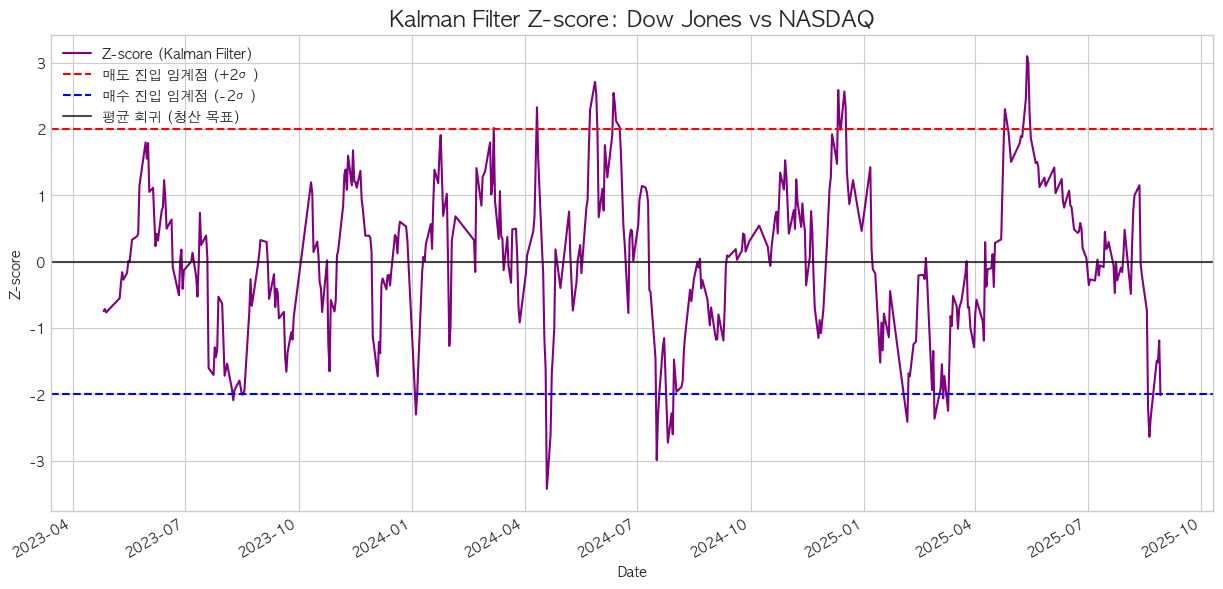


[2/2] ÌéòÏñ¥ Î∂ÑÏÑù: S&P 500 vs Dow Jones


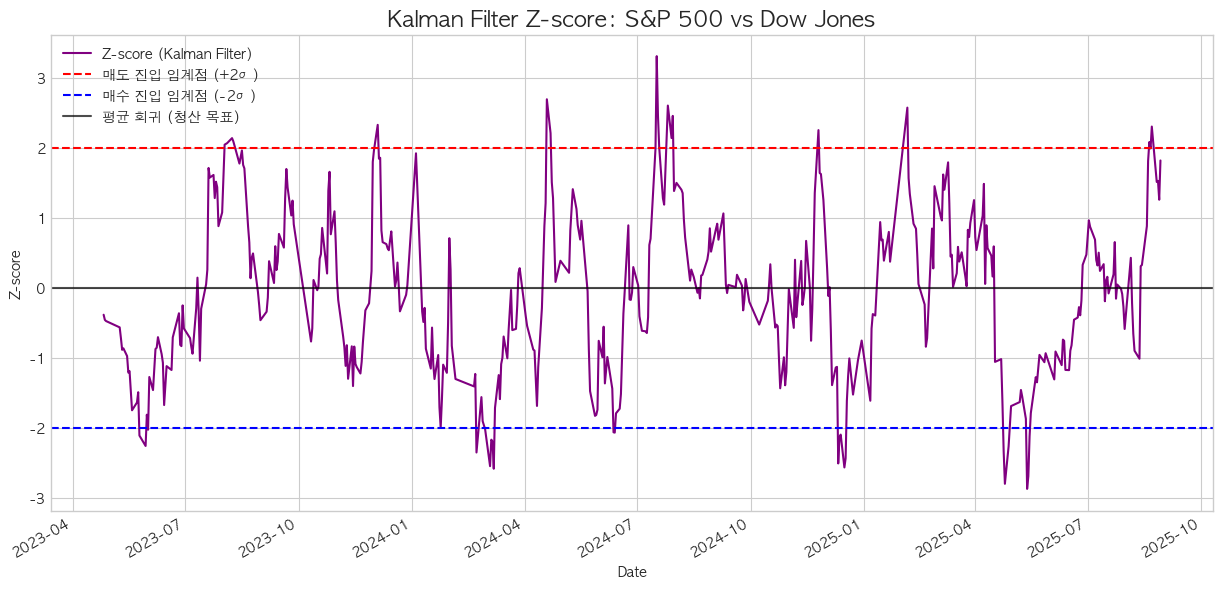

In [16]:
# -------------------------------------------
# 4. ÏπºÎßå ÌïÑÌÑ∞Î•º Ïù¥Ïö©Ìïú Ïã¨Ï∏µ Î∂ÑÏÑù Î∞è ÏãúÍ∞ÅÌôî (ÏïàÏ†ïÌôî Î≤ÑÏ†Ñ)
# -------------------------------------------
if 'KalmanFilter' in locals() and KalmanFilter is not None and 'all_intra_cluster_pairs' in locals() and all_intra_cluster_pairs:
    
    all_intra_cluster_pairs.sort(key=lambda x: x[2])
    
    print(f"\n‚úÖ [ÏπºÎßå ÌïÑÌÑ∞] Ï¥ù {len(all_intra_cluster_pairs)}Í∞ú ÌéòÏñ¥Ïóê ÎåÄÌïú Ïã¨Ï∏µ Î∂ÑÏÑùÏùÑ ÏãúÏûëÌï©ÎãàÎã§.")
    
    for i, pair_info in enumerate(all_intra_cluster_pairs):
        
        pair_to_analyze = (pair_info[0], pair_info[1])
        
        print("\n" + "="*80)
        print(f"[{i+1}/{len(all_intra_cluster_pairs)}] ÌéòÏñ¥ Î∂ÑÏÑù: {pair_to_analyze[0]} vs {pair_to_analyze[1]}")
        print("="*80)

        try:
            S1 = prices_df[pair_to_analyze[0]]
            S2 = prices_df[pair_to_analyze[1]]

            kf = KalmanFilter(
                transition_matrices=[1],
                observation_matrices=[1],
                initial_state_mean=0,
                initial_state_covariance=1,
                observation_covariance=1,
                transition_covariance=0.01
            )

            
            state_means, _ = kf.filter((S2 / S1).values)
            hedge_ratios_kf = pd.Series(state_means.flatten(), index=S1.index)

            # ÎèôÏ†Å Ïä§ÌîÑÎ†àÎìú Î∞è Z-Ïä§ÏΩîÏñ¥ Í≥ÑÏÇ∞
            spread_kf = S2 - hedge_ratios_kf * S1
            
            window = 60 
            spread_mean_kf = spread_kf.rolling(window=window).mean()
            spread_std_kf = spread_kf.rolling(window=window).std()
            z_score_kf = (spread_kf - spread_mean_kf) / spread_std_kf

            # ÏãúÍ∞ÅÌôî
            plt.figure(figsize=(15, 7))
            z_score_kf.plot(label='Z-score (Kalman Filter)', color='purple')
            plt.axhline(2.0, color='red', linestyle='--', label='Îß§ÎèÑ ÏßÑÏûÖ ÏûÑÍ≥ÑÏ†ê (+2œÉ)')
            plt.axhline(-2.0, color='blue', linestyle='--', label='Îß§Ïàò ÏßÑÏûÖ ÏûÑÍ≥ÑÏ†ê (-2œÉ)')
            plt.axhline(0, color='black', linestyle='-', alpha=0.7, label='ÌèâÍ∑† ÌöåÍ∑Ä (Ï≤≠ÏÇ∞ Î™©Ìëú)')
            plt.title(f'Kalman Filter Z-score: {pair_to_analyze[0]} vs {pair_to_analyze[1]}', fontsize=16)
            plt.ylabel('Z-score')
            plt.legend(loc='upper left')
            plt.grid(True)
            plt.show()

        except Exception as e:
            print(f"ÌéòÏñ¥ {pair_to_analyze} Î∂ÑÏÑù Ï§ë Ïò§Î•ò Î∞úÏÉù: {e}")
else:
    print("Î∂ÑÏÑùÌï† ÌéòÏñ¥Í∞Ä ÏóÜÏùå")